In [1]:
import os
import sys
cwd = os.path.abspath('')
cwd_parent, _ = os.path.split(cwd)
sys.path.append(cwd_parent)

from importlib import reload

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np
import clip
import torch
from random import randint

from NegCLIP.COCO_Dataset import COCODataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
model, preprocess = clip.load("ViT-B/32", device="cpu")

In [3]:
SET_TYPE = "val"
BATCH_SIZE = 3
COCO_ORDER_PATH = "../ARO_benchmark/COCO_Order/captions_shuffled_captions.json"


coco_dts = COCODataset(root=f'../COCO/{SET_TYPE}2014/', pairwise_sim_path=f"../COCO/pairwise_sim/{SET_TYPE}.csv",
                           annFile=f'../COCO/annotations/captions_negcaptions_{SET_TYPE}2014.json',
                           transform=preprocess, target_transform=clip.tokenize)
dts_size = len(coco_dts)
coco_loader = DataLoader(coco_dts, batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=2.16s)
creating index...
index created!


In [29]:
text_embedding = torch.Tensor()
y = []
for i, data in tqdm(enumerate(coco_loader), leave=False, total=len(coco_loader)):
    images, captions = data
    b, _, _, _, _ = images.shape
    captions_pos = captions[:, 0:2, :].flatten(0, 1)
    captions_neg = captions[:, 2:, :].flatten(0, 1)
  
    encoded_text = model.encode_text(torch.cat((captions_pos, captions_neg))) 
    encoded_text = encoded_text/encoded_text.norm(dim=1, keepdim=True)
    logits = model.logit_scale * encoded_text @ encoded_text.t()
    text_embedding = torch.cat((text_embedding, encoded_text))
    y = y+[1]*2*b +[0]*2*b

    if i==10:
        break
print(text_embedding.shape)
y = np.array(y)
print(y.shape)

torch.Size([132, 512])
(132,)


In [30]:
x = TSNE(n_components=2, perplexity=15).fit_transform(text_embedding.detach().numpy())

/home/teo/anaconda3/envs/clip_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/teo/anaconda3/envs/clip_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


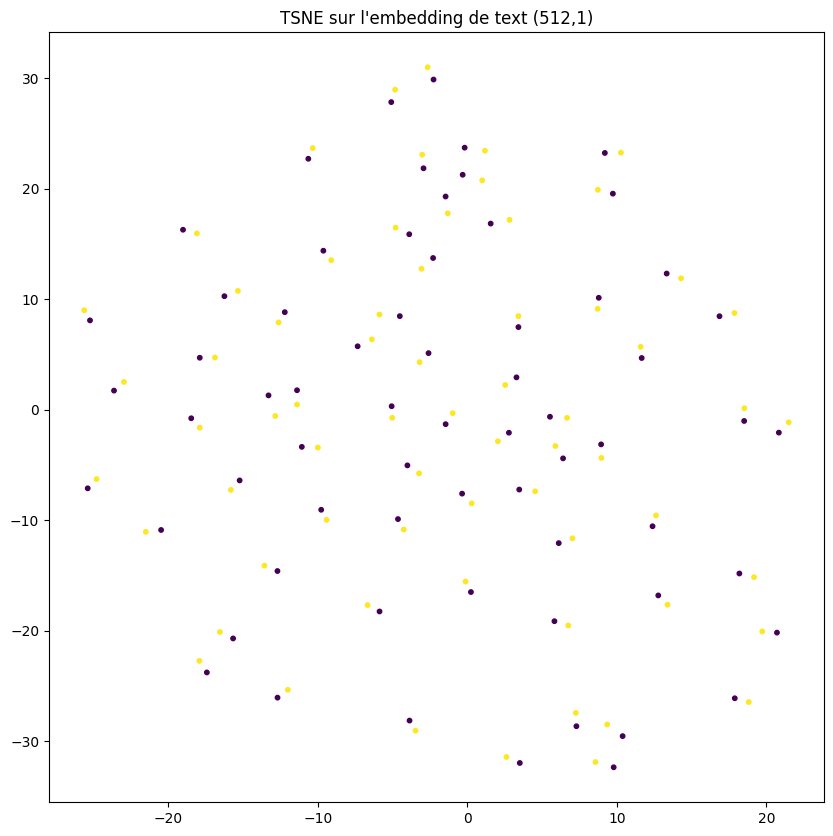

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title("TSNE sur l'embedding de text (512,1)")
line = ax.scatter(x[:,0],x[:,1], c=y, s=10)          
plt.show()